 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [2]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import  SubsetRandomSampler

from tqdm.auto import tqdm
from tqdm import notebook

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import pandas as pd

Скачаем обучающую и контрольную выборки.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

indices = list(range(len(trainset)))
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=4, num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=4, num_workers=2)

types = pd.DataFrame((
  "T-shirt/top",
  "Trouser",
  "Pullover",
  "Dress",
  "Coat", 
  "Sandal", 
  "Shirt",
  "Sneaker",
  "Bag",
  "Ankle boot"
), columns=['class_name'])

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
print("Number of images in the train sample - ", trainloader.dataset.data.shape)
print("Number of images in the test sample - ", testloader.dataset.data.shape)

Number of images in the train sample -  torch.Size([60000, 28, 28])
Number of images in the test sample -  torch.Size([10000, 28, 28])


In [ ]:
print("A number of items in each class of train sample - ", trainset.targets.unique(return_counts=True)[1])
print("A number of items in each class of train sample - ", testset.targets.unique(return_counts=True)[1])

A number of items in each class of train sample -  tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
A number of items in each class of train sample -  tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])


Видим, что в каждом классе примерно равное количество объектов как в обучающей выборке, так и тестововой.

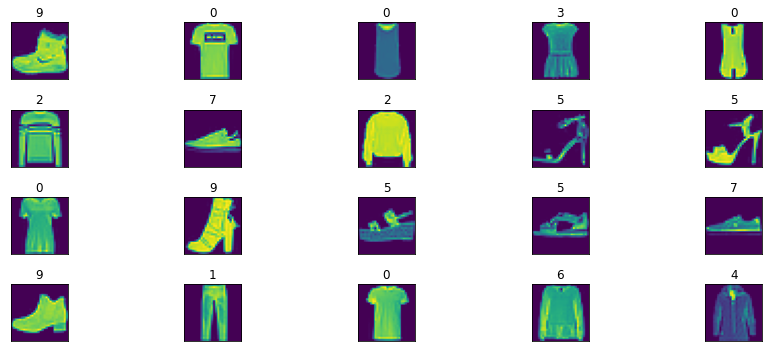

In [ ]:
fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(trainset.data[idx])
  ax.set_title(trainset.targets[idx].item())
  fig.tight_layout()

In [6]:
def fit_model(model, optimizer, loss_fn, epochs, lr):
  train_losses, valid_losses = [],[]
  for epoch in range(epochs):
    running_loss =0 
    valid_loss = 0
    
    for images, labels in trainloader:

      optimizer.zero_grad()
      log_ps = model(images)
      loss = loss_fn(log_ps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() / len(trainloader.sampler)
    
    for images, labels in validloader:
      log_ps = model(images)
      loss = loss_fn(log_ps, labels)
      valid_loss += loss.item() / len(validloader.sampler)

    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch+1,
          running_loss,
          valid_loss
      ))
  return train_losses, valid_losses

In [7]:
def get_metrics(model, testloader):  
  y_true, y_pred = [], []
  with torch.no_grad():
    for data, labels in testloader:
      y_pred_batch = torch.argmax(model(data), 1)
      y_true.extend(labels)
      y_pred.extend(y_pred_batch)
  print(classification_report(y_pred, y_true))

**CNN** 

In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=128)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [11]:
class ConvNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(ConvNet, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
    self.conv4 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = torch.nn.Linear(D_in, H[0])
    self.fc2 = torch.nn.Linear(H[0], H[1])
    self.fc3 = torch.nn.Linear(H[1], H[1])
    self.fc4 = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool2(x)
    #print(x.shape)
    x = x.view(-1, D_in)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)

    return x

In [18]:
m = nn.MaxPool2d(2, stride=2)
conv = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
input = torch.randn(20, 16, 50, 32)
output = conv(input)
output.shape

torch.Size([20, 32, 48, 30])

In [12]:
D_in, H, D_out = 64, [256, 128], 10

cnn_model = ConvNet(D_in, H, D_out)
#cnn_model = FashionCNN()
#cnn_model = SimpleConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

train_losses, valid_losses = fit_model(model=cnn_model, optimizer=optimizer, loss_fn=loss_fn, epochs=5, lr=learning_rate)

KeyboardInterrupt: ignored

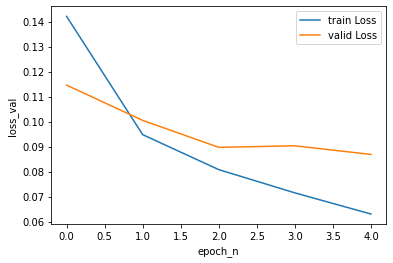

In [ ]:
plt.plot(train_losses, label='train Loss')
plt.plot(valid_losses, label='valid Loss')
plt.ylabel('loss_val')
plt.xlabel('epoch_n')

plt.legend()

In [ ]:
get_metrics(cnn_model, testloader)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       841
           1       0.98      0.97      0.98      1014
           2       0.76      0.86      0.80       882
           3       0.83      0.92      0.87       910
           4       0.89      0.74      0.81      1191
           5       0.93      0.98      0.96       950
           6       0.72      0.62      0.67      1153
           7       0.97      0.91      0.94      1065
           8       0.97      0.97      0.97      1001
           9       0.95      0.96      0.96       993

    accuracy                           0.87     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.87      0.87     10000



**MLP**

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(MLP, self).__init__()
    self.fc1 = torch.nn.Linear(D_in, H[0])
    self.relu1 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(H[0], H[1])
    self.relu2 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(H[1], H[1])
    self.relu3 = torch.nn.ReLU()
    self.fc4 = torch.nn.Linear(H[1], D_out)
  
  def forward(self, x):
    x = x.view(-1, D_in)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    x = self.relu3(x)
    x = self.fc4(x)
    return x

In [ ]:
D_in, H, D_out = 784, [128, 64], 10

mlp_model = MLP(D_in, H, D_out)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)

train_losses, valid_losses = fit_model(model=mlp_model, optimizer=optimizer, loss_fn=loss_fn, epochs=10, lr=learning_rate)

Epoch: 1 	Training Loss: 0.239832 	Validation Loss: 0.163689
Epoch: 2 	Training Loss: 0.143938 	Validation Loss: 0.141055
Epoch: 3 	Training Loss: 0.126277 	Validation Loss: 0.127774
Epoch: 4 	Training Loss: 0.116349 	Validation Loss: 0.123159
Epoch: 5 	Training Loss: 0.110435 	Validation Loss: 0.117849
Epoch: 6 	Training Loss: 0.105200 	Validation Loss: 0.112098
Epoch: 7 	Training Loss: 0.100482 	Validation Loss: 0.116017
Epoch: 8 	Training Loss: 0.096663 	Validation Loss: 0.107787
Epoch: 9 	Training Loss: 0.093070 	Validation Loss: 0.104996
Epoch: 10 	Training Loss: 0.089773 	Validation Loss: 0.105320


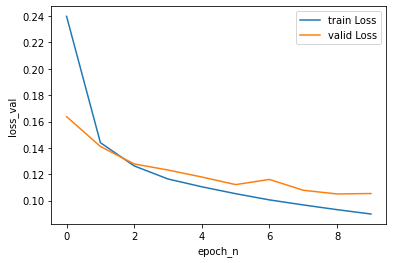

In [ ]:
plt.plot(train_losses, label='train Loss')
plt.plot(valid_losses, label='valid Loss')
plt.ylabel('loss_val')
plt.xlabel('epoch_n')

plt.legend()

In [ ]:
get_metrics(mlp_model, testloader)

              precision    recall  f1-score   support

           0       0.75      0.84      0.80       892
           1       0.96      0.97      0.97       988
           2       0.80      0.72      0.75      1109
           3       0.89      0.78      0.83      1147
           4       0.67      0.78      0.72       858
           5       0.91      0.96      0.93       949
           6       0.62      0.63      0.63       987
           7       0.94      0.89      0.92      1064
           8       0.96      0.94      0.95      1017
           9       0.93      0.94      0.93       989

    accuracy                           0.84     10000
   macro avg       0.84      0.85      0.84     10000
weighted avg       0.85      0.84      0.84     10000



Обе нейронные сети дают в принципе неплохой результат: mlp - 0.84, cnn - 0.87. Тем не менее cnn, как и предполагалось, справилась лучше.